# PLANETOID - Cora Dataset

This tutorial follows the one provided from https://colab.research.google.com/drive/1d0jLDwgNBtjBVQOFe8lO_1WrqTVeVZx9?usp=sharing#scrollTo=sjX6CPJFA52R

Cora is part of the Planetoid collection of datasets, specifically designed for semi-supervised learning on graph-structured data. It represents a citation network of scientific publications in computer science. Each node in the graph is a research paper, with the undirected edges describing a citation relationship.

## Basic Statistics
- Documents: 2,708 scientific papers
- Citation Links: 5,429 edges
- Classes: 7 categories
- Features per Node: 1,433 binary features

## Classes
- Case Based
- Genetic Algorithms
- Neural Networks
- Probabilistic Methods
- Reinforcement Learning
- Rule Learning
- Theory

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import torch
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

In [3]:
transformations = NormalizeFeatures()

dataset = Planetoid(
    root='./data',
    name='Cora',
    transform=transformations
)
data = dataset[0]

The data object wraps each graph

In [35]:
data

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

We can use some built in methods and check the available features

In [36]:
data.x

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [37]:
data.y

tensor([3, 4, 4,  ..., 3, 3, 3])

In [38]:
data.num_nodes

2708

In [39]:
data.is_undirected()

True

In [40]:
data.edge_index

tensor([[ 633, 1862, 2582,  ...,  598, 1473, 2706],
        [   0,    0,    0,  ..., 2707, 2707, 2707]])

We can also compute some statistics about the dataset

In [41]:
# Basic feature statistics
feature_sums = data.x.sum(dim=0)
feature_density = (data.x > 0).float().mean()

print("\nFeature Analysis:")
print(f"Feature matrix shape: {data.x.shape}")
print(f"Average feature density: {feature_density:.4f}")
print(f"Number of non-zero features: {(feature_sums > 0).sum().item()}")

# Class distribution
class_counts = torch.bincount(data.y)
print("\nClass Distribution:")
for i, count in enumerate(class_counts):
    print(f"Class {i}: {count.item()} nodes")


Feature Analysis:
Feature matrix shape: torch.Size([2708, 1433])
Average feature density: 0.0127
Number of non-zero features: 1432

Class Distribution:
Class 0: 351 nodes
Class 1: 217 nodes
Class 2: 418 nodes
Class 3: 818 nodes
Class 4: 426 nodes
Class 5: 298 nodes
Class 6: 180 nodes


Networkx is a well know library to deal with small size graphs for non ML related tasks, we can use the utils from pyg to convert and plot the graph

In [42]:
import networkx as nx
from torch_geometric.utils import to_networkx
import numpy as np

G = to_networkx(data, to_undirected=True)

# Define a color palette (using tab20 for better distinction between classes)
num_classes = len(torch.unique(data.y))
colors = plt.cm.tab20(np.linspace(0, 1, num_classes))

# Create color map based on node classes
color_map = [colors[data.y[i].item()] for i in range(data.num_nodes)]

# Calculate layout (this can be computationally expensive for large graphs)
pos = nx.spring_layout(G, k=0.05, iterations=50)


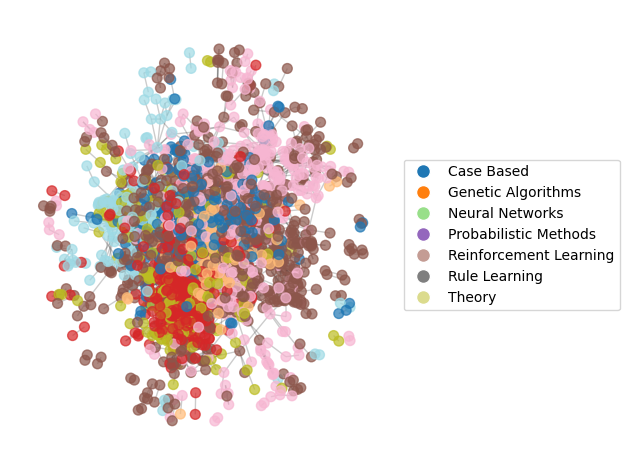

In [43]:
plt.figure()

# Draw edges
nx.draw_networkx_edges(G, pos, alpha=0.2)

# Draw nodes
nx.draw_networkx_nodes(G, pos,
                        node_color=color_map,
                        node_size=50,
                        alpha=0.7)

plt.axis('off')

# Add legend
class_names = ['Case Based', 'Genetic Algorithms', 'Neural Networks',
                'Probabilistic Methods', 'Reinforcement Learning',
                'Rule Learning', 'Theory']

# Create legend patches
legend_elements = [plt.Line2D([0], [0], marker='o', color='w',
                                markerfacecolor=plt.cm.tab20(i/7),
                                label=class_names[i], markersize=10)
                    for i in range(7)]

plt.legend(handles=legend_elements, loc='center left',
            bbox_to_anchor=(1, 0.5))

plt.tight_layout()

# GML Model

The dataset already provides the splits, so we can use the masks to inspect them

In [25]:
# check training nodes
print("# of nodes to train on: ", data.train_mask.sum().item())

# check test nodes
print("# of nodes to test on: ", data.test_mask.sum().item())

# check validation nodes
print("# of nodes to validate on: ", data.val_mask.sum().item())

# of nodes to train on:  140
# of nodes to test on:  1000
# of nodes to validate on:  500


Check the availability of the GPU to train

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

We can now define our model: 
- it should inherit from torch.nn.Module
- in the __init__ we can define the layers and the overall components on the architecture
- the forward function is the funtion that is executed when we input data to the model as model(data)
- this is a multiclass problem, the softmax layer in the end make the results as a probability distribution and we simply select the maximum value

In [5]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        """ GCNConv layers """
        self.conv1 = GCNConv(data.num_features, 16)
        self.conv2 = GCNConv(16, 16)
        self.conv3 = GCNConv(16, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        self.embeddings = x
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv3(x, edge_index)

        return F.log_softmax(x, dim=1)
    
    def get_embeddings(self):
        return self.embeddings

We need to instantiate it and move to the device, and we can also define the optimizer

In [6]:
model = GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

In [7]:
# helper function to compute accuracy
def compute_accuracy(pred_y, y):
    return (pred_y == y).sum()

### Training Loop
We can now define the training loop. At each time step we should:
- reset the gradient 
- forward the input to obtain the prediction
- compute the loss function
- backpropagate to get the gradients
- update the parameters of the model in the opposite direction of the gradient

### Loss Function
Negative Log Likelihood expects log probabilities (should be better computationally), which is equivalent as using Cross Entropy

### Validation
Validation is a part of the dataset that is used for monitoring and the model is not learning from that. So, we should remove gradient computation to have an unbiased evaluation

In [8]:
# Initialize history
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

# Move data to device
data.to(device)

# Training loop
epochs = 200
model.train()
for epoch in range(epochs):
    # Training step
    optimizer.zero_grad()
    out = model(data)
    
    # Calculate training metrics
    train_loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    train_pred = out.argmax(dim=1)[data.train_mask]
    train_correct = compute_accuracy(train_pred, data.y[data.train_mask])
    train_acc = float(train_correct) / int(data.train_mask.sum())
    
    # Backpropagation
    train_loss.backward()
    optimizer.step()
    
    # Validation step
    model.eval()
    with torch.no_grad():
        # Calculate validation metrics
        val_loss = F.nll_loss(out[data.val_mask], data.y[data.val_mask])
        val_pred = out.argmax(dim=1)[data.val_mask]
        val_correct = compute_accuracy(val_pred, data.y[data.val_mask])
        val_acc = float(val_correct) / int(data.val_mask.sum())
    model.train()
    
    # Store metrics
    history['train_loss'].append(train_loss.item())
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss.item())
    history['val_acc'].append(val_acc)
    
    # Print progress
    if (epoch + 1) % 10 == 0:
        print(f'Epoch: {epoch+1:03d}, '
                f'Train Loss: {train_loss:.4f}, '
                f'Train Acc: {train_acc:.4f}, '
                f'Val Loss: {val_loss:.4f}, '
                f'Val Acc: {val_acc:.4f}')

Epoch: 010, Train Loss: 1.8875, Train Acc: 0.2643, Val Loss: 1.9135, Val Acc: 0.2160
Epoch: 020, Train Loss: 1.7005, Train Acc: 0.5071, Val Loss: 1.8073, Val Acc: 0.3660
Epoch: 030, Train Loss: 1.4200, Train Acc: 0.5714, Val Loss: 1.6212, Val Acc: 0.4400
Epoch: 040, Train Loss: 1.0656, Train Acc: 0.7071, Val Loss: 1.4274, Val Acc: 0.4580
Epoch: 050, Train Loss: 0.8125, Train Acc: 0.8214, Val Loss: 1.2307, Val Acc: 0.5900
Epoch: 060, Train Loss: 0.5885, Train Acc: 0.8929, Val Loss: 1.0909, Val Acc: 0.6500
Epoch: 070, Train Loss: 0.4422, Train Acc: 0.9000, Val Loss: 1.0335, Val Acc: 0.6620
Epoch: 080, Train Loss: 0.3565, Train Acc: 0.9286, Val Loss: 1.0454, Val Acc: 0.6960
Epoch: 090, Train Loss: 0.2927, Train Acc: 0.9429, Val Loss: 0.9389, Val Acc: 0.7000
Epoch: 100, Train Loss: 0.2368, Train Acc: 0.9786, Val Loss: 0.9616, Val Acc: 0.6740
Epoch: 110, Train Loss: 0.2786, Train Acc: 0.9571, Val Loss: 1.0696, Val Acc: 0.6720
Epoch: 120, Train Loss: 0.2197, Train Acc: 0.9643, Val Loss: 1.01

If we plot loss and accuracy on the validation set we can inspect how the training evolved

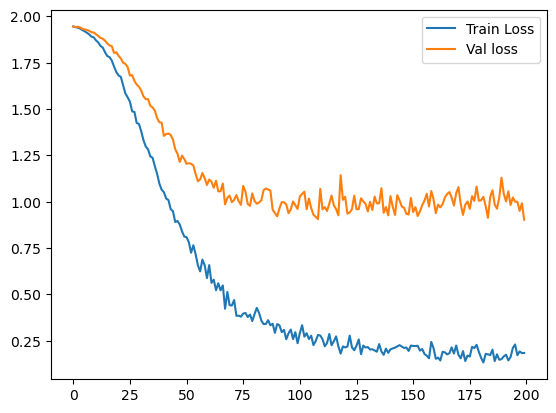

In [9]:
plt.plot(history['train_loss'])
plt.plot(history['val_loss'])
plt.legend(['Train Loss', 'Val loss'])
plt.show()

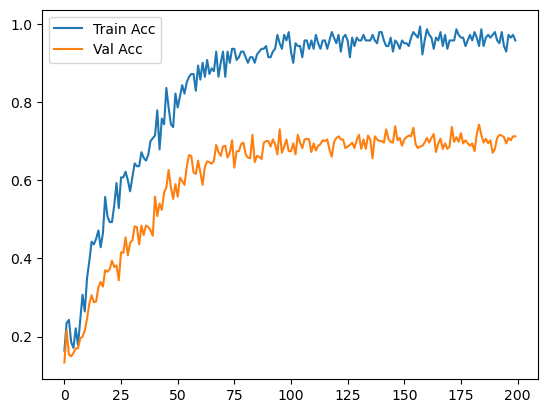

In [10]:
plt.plot(history['train_acc'])
plt.plot(history['val_acc'])
plt.legend(['Train Acc', 'Val Acc'])
plt.show()

# Embeddings

We can use the trained model to embed the test data

In [22]:
model.eval()
with torch.no_grad():
    _ = model(data)
    embeddings = model.get_embeddings()

# we get only the test data and move them back on cpu
test_mask = data.test_mask.cpu().numpy()
test_embeddings = embeddings[test_mask].cpu().numpy()
test_labels = data.y[test_mask].cpu().numpy()

We can use dimensionality reduction techniques to plot the embeddings

In [12]:
from sklearn.manifold import TSNE

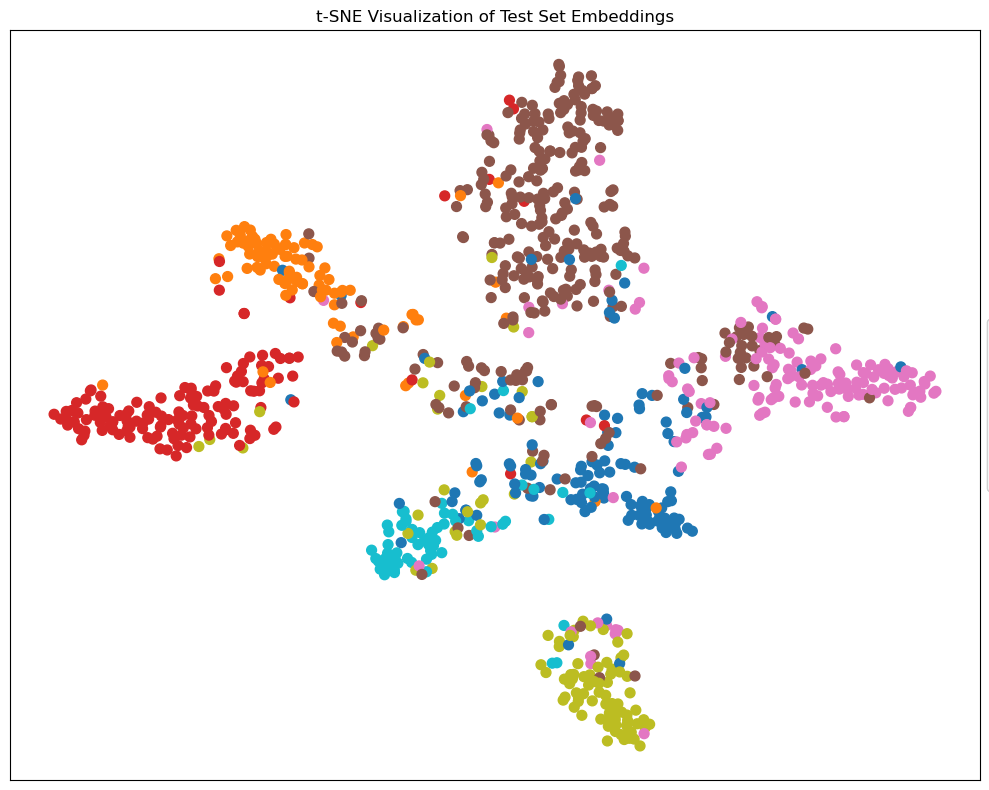

In [27]:
tsne = TSNE(n_components=2)
tsne_embeddings = tsne.fit_transform(test_embeddings)

# Create figure
fig, ax = plt.subplots(figsize=(10, 8))

# Plot t-SNE
scatter = ax.scatter(tsne_embeddings[:, 0], 
                    tsne_embeddings[:, 1],
                    c=test_labels,
                    cmap='tab10',
                    alpha=1,
                    s=50)

# Add legend
legend1 = ax.legend(*scatter.legend_elements(),
                   loc="center left",
                   title="Classes",
                   bbox_to_anchor=(1, 0.5))
ax.add_artist(legend1)

# Remove ticks
ax.set_xticks([])
ax.set_yticks([])

# Add title
plt.title('t-SNE Visualization of Test Set Embeddings')
plt.tight_layout()